# Citi Bike Trips vs Weather (2022)

**Goal:** Create Matplotlib visualizations showing daily average temperature and Citi Bike trip counts in 2022.

In [8]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

PROJECT_ROOT = os.getcwd()
print("Working directory:", PROJECT_ROOT)

# Paths used in this project
RAW_WEATHER_PATH = r"Data/Raw/weather_lga_2022.csv"
PROCESSED_WEATHER_DAILY_PATH = r"Data/Processed/citibike_weather_daily_2022.csv"   # may already exist
PROCESSED_DAILY_TRIPS_PATH = r"Data/Processed/daily_trips_2022.csv"              # recommended output
MERGED_OUT_PATH = r"Data/Processed/citibike_weather_merged_2022.csv"

Working directory: C:\Users\User\Downloads\Citibike-Weather-Dashboard


In [9]:
def build_weather_daily_2022():

    if os.path.exists(PROCESSED_WEATHER_DAILY_PATH):
        w = pd.read_csv(PROCESSED_WEATHER_DAILY_PATH)
        if "date" in w.columns:
            w["date"] = pd.to_datetime(w["date"], errors="coerce")
        else:
            w.iloc[:, 0] = pd.to_datetime(w.iloc[:, 0], errors="coerce")
            w = w.rename(columns={w.columns[0]: "date"})
        if "temp_avg_c" not in w.columns:
            # Try to find an avg temp column
            cand = [c for c in w.columns if ("temp" in c.lower() and "avg" in c.lower()) or c.lower() in ("tavg","tmean")]
            if cand:
                w = w.rename(columns={cand[0]: "temp_avg_c"})
        w = w[["date", "temp_avg_c"]].copy() if "temp_avg_c" in w.columns else w.copy()
    else:
        if not os.path.exists(RAW_WEATHER_PATH):
            raise FileNotFoundError(f"Weather file not found at: {RAW_WEATHER_PATH}")
        raw = pd.read_csv(RAW_WEATHER_PATH)

        # Detect date column
        date_candidates = [c for c in raw.columns if "date" in c.lower() or "time" in c.lower()]
        if not date_candidates:
            raise KeyError(f"No date-like column found in raw weather. Columns: {raw.columns.tolist()}")
        date_col = date_candidates[0]

        # Detect average temperature column
        temp_candidates = [c for c in raw.columns if ("temp" in c.lower() and "avg" in c.lower()) or c.lower() in ("tavg","tmean")]
        if not temp_candidates:
            # fallback: any column containing 'tavg'
            temp_candidates = [c for c in raw.columns if "tavg" in c.lower()]
        if not temp_candidates:
            raise KeyError(f"No average temperature column found in raw weather. Columns: {raw.columns.tolist()}")
        temp_col = temp_candidates[0]

        w = raw[[date_col, temp_col]].copy()
        w = w.rename(columns={date_col: "date", temp_col: "temp_avg_c"})

    # Parse types
    w["date"] = pd.to_datetime(w["date"], errors="coerce")
    w["temp_avg_c"] = pd.to_numeric(w["temp_avg_c"], errors="coerce")

    # Keep only 2022
    w = w.dropna(subset=["date"]).sort_values("date")
    w = w[(w["date"] >= "2022-01-01") & (w["date"] <= "2022-12-31")]

    # Force full daily coverage for 2022
    full_dates = pd.date_range("2022-01-01", "2022-12-31", freq="D")
    w = w.set_index("date").reindex(full_dates)
    w.index.name = "date"

    # Fill any missing temperatures (interpolation is reasonable for daily temps)
    w["temp_avg_c"] = w["temp_avg_c"].interpolate(limit_direction="both")

    # Save standardized daily file for reuse
    os.makedirs(os.path.dirname(PROCESSED_WEATHER_DAILY_PATH), exist_ok=True)
    w.reset_index().to_csv(PROCESSED_WEATHER_DAILY_PATH, index=False)

    return w.reset_index()

weather_daily = build_weather_daily_2022()

print("Weather daily range:", weather_daily["date"].min(), "to", weather_daily["date"].max())
print("Missing temp_avg_c:", weather_daily["temp_avg_c"].isna().sum())
weather_daily.head()


Weather daily range: 2022-01-01 00:00:00 to 2022-12-31 00:00:00
Missing temp_avg_c: 0


,date,temp_avg_c
0,2022-01-01,11.6
1,2022-01-02,11.4
2,2022-01-03,1.4
3,2022-01-04,-2.7
4,2022-01-05,3.2


In [10]:
def build_daily_trips_2022():
    
    if os.path.exists(PROCESSED_DAILY_TRIPS_PATH):
        t = pd.read_csv(PROCESSED_DAILY_TRIPS_PATH, parse_dates=["date"])
        return t[["date", "daily_trips"]].sort_values("date")

    if os.path.exists(PROCESSED_WEATHER_DAILY_PATH):
        tmp = pd.read_csv(PROCESSED_WEATHER_DAILY_PATH, parse_dates=["date"])
        if "daily_trips" in tmp.columns:
            t = tmp[["date", "daily_trips"]].copy().sort_values("date")
            # Save for future runs
            t.to_csv(PROCESSED_DAILY_TRIPS_PATH, index=False)
            return t

    trip_files = sorted(glob.glob(r"Data/Raw/citibike-2022/*.csv"))
    if not trip_files:
        raise FileNotFoundError(
            "No processed daily trips file found and no raw trip CSVs found under Data/Raw/citibike-2022/. "
            "Create daily trips first (recommended) or place trip CSVs in that folder."
        )

    sample_cols = pd.read_csv(trip_files[0], nrows=1).columns.tolist()
    start_col = "started_at" if "started_at" in sample_cols else ("starttime" if "starttime" in sample_cols else None)
    if start_col is None:
        raise KeyError(f"Could not find a trip start-time column in trip CSVs. Columns: {sample_cols}")

    trips = pd.concat((pd.read_csv(f, usecols=[start_col], low_memory=False) for f in trip_files), ignore_index=True)
    trips[start_col] = pd.to_datetime(trips[start_col], errors="coerce")
    trips = trips.dropna(subset=[start_col])

    daily = (
        trips.set_index(start_col)
             .sort_index()
             .loc["2022-01-01":"2022-12-31"]
             .resample("D")
             .size()
             .rename("daily_trips")
             .to_frame()
             .reset_index()
             .rename(columns={start_col: "date"})
    )

    daily.to_csv(PROCESSED_DAILY_TRIPS_PATH, index=False)
    return daily

daily_trips = build_daily_trips_2022()

print("Trips daily range:", daily_trips["date"].min(), "to", daily_trips["date"].max())
print("Rows:", len(daily_trips))
daily_trips.head()

Trips daily range: 2022-01-01 00:00:00 to 2022-12-31 00:00:00
Rows: 365


,date,daily_trips
0,2022-01-01,592
1,2022-01-02,1248
2,2022-01-03,832
3,2022-01-04,934
4,2022-01-05,914


In [11]:
print("TRIPS range:", daily_trips["date"].min(), daily_trips["date"].max())
print(daily_trips["date"].dt.month.value_counts().sort_index())

print("WEATHER range:", weather_daily["date"].min(), weather_daily["date"].max())
print(weather_daily["date"].dt.month.value_counts().sort_index())

TRIPS range: 2022-01-01 00:00:00 2022-12-31 00:00:00
date
1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: count, dtype: int64
WEATHER range: 2022-01-01 00:00:00 2022-12-31 00:00:00
date
1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: count, dtype: int64


In [12]:
final_df = pd.merge(
    daily_trips,
    weather_daily[["date", "temp_avg_c"]],
    on="date",
    how="left"
)
# Sanity checks
print("Merged range:", final_df["date"].min(), "to", final_df["date"].max())
print("Missing temp_avg_c:", final_df["temp_avg_c"].isna().sum())
print("Rows:", len(final_df))

# Save the single merged file used by downstream notebooks
final_df.to_csv(MERGED_OUT_PATH, index=False)
final_df.head()

Merged range: 2022-01-01 00:00:00 to 2022-12-31 00:00:00
Missing temp_avg_c: 0
Rows: 365


,date,daily_trips,temp_avg_c
0,2022-01-01,592,11.6
1,2022-01-02,1248,11.4
2,2022-01-03,832,1.4
3,2022-01-04,934,-2.7
4,2022-01-05,914,3.2


In [13]:
suffix = final_df[final_df["date"] >= "2022-09-07"]["temp_avg_c"]
print("Unique temps from 2022-09-07 onward:", suffix.nunique())
print(suffix.describe())

Unique temps from 2022-09-07 onward: 1
count    116.0
mean      20.8
std        0.0
min       20.8
25%       20.8
50%       20.8
75%       20.8
max       20.8
Name: temp_avg_c, dtype: float64


In [20]:
check = pd.read_csv(MERGED_OUT_PATH, parse_dates=["date"])
print("SAVED FILE range:", check["date"].min(), check["date"].max())
print(check["date"].dt.month.value_counts().sort_index())

SAVED FILE range: 2022-01-01 00:00:00 2022-12-31 00:00:00
date
1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: count, dtype: int64


In [19]:
final_df = pd.merge(
    daily_trips,
    weather_daily[["date", "temp_avg_c"]],
    on="date",
    how="left"
)

print("MERGED range:", final_df["date"].min(), final_df["date"].max())
print("MERGED months:", final_df["date"].dt.month.value_counts().sort_index())
print("Rows:", len(final_df))
print("NaNs in temp_avg_c:", final_df["temp_avg_c"].isna().sum())

MERGED range: 2022-01-01 00:00:00 2022-12-31 00:00:00
MERGED months: date
1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: count, dtype: int64
Rows: 365
NaNs in temp_avg_c: 0


In [15]:
print("MERGED range:", final_df["date"].min(), final_df["date"].max())
print(final_df["date"].dt.month.value_counts().sort_index())

MERGED range: 2022-01-01 00:00:00 2022-12-31 00:00:00
date
1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: count, dtype: int64


In [17]:
raw_weather = pd.read_csv(RAW_WEATHER_PATH)
raw_weather["date"] = pd.to_datetime(raw_weather["date"], errors="coerce")
print(raw_weather["date"].min(), raw_weather["date"].max())
print(raw_weather["date"].dt.month.value_counts().sort_index())

2022-01-01 00:00:00 2022-09-07 00:00:00
date
1    31
2    28
3    31
4    30
5    31
6    30
7    31
8    31
9     7
Name: count, dtype: int64


In [18]:
print(daily_trips["date"].min(), daily_trips["date"].max())

2022-01-01 00:00:00 2022-12-31 00:00:00


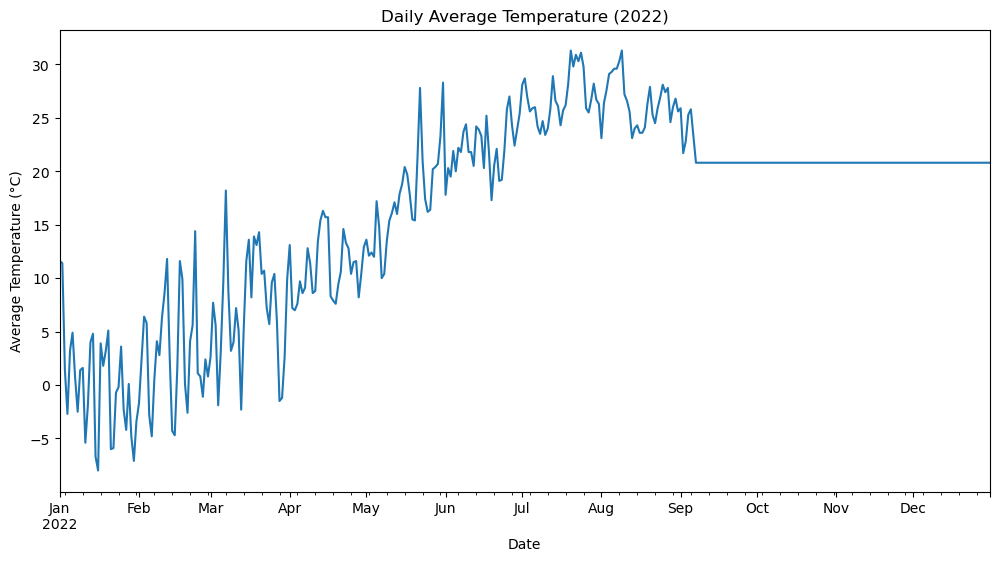

In [5]:
ax = weather_daily.plot(
    x="date",
    y="temp_avg_c",
    title="Daily Average Temperature (2022)",
    legend=False
)
ax.set_xlabel("Date")
ax.set_ylabel("Average Temperature (°C)")
plt.show()

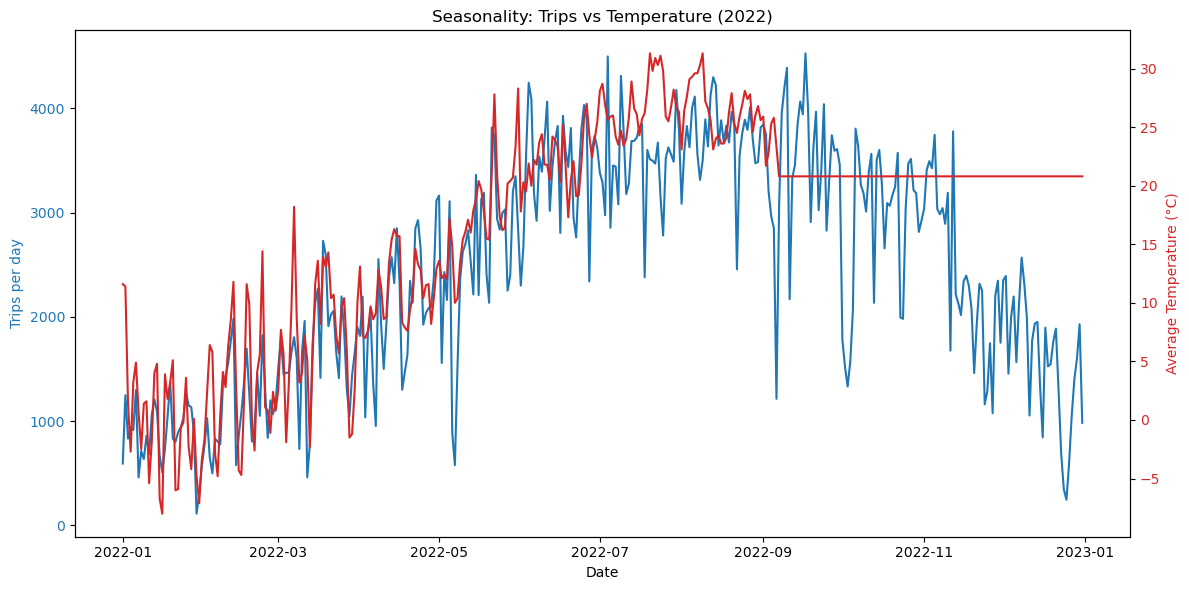

In [6]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis: trips
ax1.plot(final_df["date"], final_df["daily_trips"], color="tab:blue", label="Trips per day")
ax1.set_xlabel("Date")
ax1.set_ylabel("Trips per day", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right axis: temperature
ax2 = ax1.twinx()
ax2.plot(final_df["date"], final_df["temp_avg_c"], color="tab:red", label="Avg Temperature (°C)")
ax2.set_ylabel("Average Temperature (°C)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Seasonality: Trips vs Temperature (2022)")
fig.tight_layout()
plt.show()

## Notes on Matplotlib usage

- The temperature time series uses **pandas `.plot()`**, which is a thin wrapper around Matplotlib.
- The dual-axis chart uses Matplotlib’s **object-oriented (OO) interface**:
  - `fig, ax1 = plt.subplots()` creates a figure and primary axes.
  - `ax1.twinx()` creates a second y-axis (`ax2`) that shares the same x-axis.
  - This OO approach provides explicit control over axes, labels, and formatting.
